In [1]:
#importing all the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, BatchNormalization
from keras.optimizers import Adam, Adagrad
from keras import regularizers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from gensim.models import KeyedVectors
from sklearn.preprocessing import LabelEncoder
import pickle
import random

In [2]:
random.seed(666)

Loading the dataset

In [3]:
df = pd.read_csv("new_complaints3.csv") 

The data splited into feature and target.

In [4]:
X_data = df['new']
y_data = df['Product']

In [5]:
X_data

0         transworld systems inc \nis trying to collect ...
1         Over the past 2 weeks I have been receiving ex...
2         Pioneer has committed several federal violatio...
3         Previously on XX XX XXXX XX XX XXXX and XX XX ...
4         Hello This complaint is against the three cred...
                                ...                        
597869    1  Mailing Address is incorrect \n2  Date of B...
597870    I made a purchase of ##### on XXXX XXXX #### u...
597871    On XXXX XXXX #### I contacted XXXX XXXX who is...
597872    I can not get from chase who services my mortg...
597873    cfbp i would Like to file a complaint on Exper...
Name: new, Length: 597874, dtype: object

The DataFrame converted to a NumPy array.

In [6]:
X = X_data.values
y = y_data.values

The data splitted into train and test set, the train set is 80 percent of the data, and the test set is 20 percent. The data is stratified based on the label.

In [7]:
X_train_value, X_val_value, y_train_value, y_val_value = train_test_split(X, y, 
                                                                          test_size=0.4, 
                                                                          random_state=666, 
                                                                          stratify=y)

Vocabulary was built based on the unique words from the train set.

In [8]:
tokenizer = Tokenizer(lower=False)
tokenizer.fit_on_texts(X_train_value)

In [9]:
vocab = tokenizer.word_index

In [10]:
vocab_size = len(vocab)

In [11]:
vocab_size

159487

Creating an empty weight matrix for words in document vocabulary, +1 because the word index dictionary value starting from 1

In [12]:
embedding_matrix = np.zeros((vocab_size+1, 300))

Fill in the embedding matrix

In [13]:
vectors = KeyedVectors.load('vectors.kv')

In [14]:
for word, i in tokenizer.word_index.items():
    try:
        embedding_vector = vectors[word]
        embedding_matrix[i] = embedding_vector
    except:
        embedding_vector = vectors['UNK']
        embedding_matrix[i] = embedding_vector

In [15]:
X_train = tokenizer.texts_to_sequences(X_train_value)
X_val = tokenizer.texts_to_sequences(X_val_value)

Sanity check

In [16]:
len(X_val_value[1].split())

106

In [17]:
X_val_value[7]

'I previously tried to settle this matter with experian about unauthorized inquiries on my consumer report i sent them a letter explaining the problem trying to get experian to resolve the issue but they never did On XX XX #### i sent out another letter certified about the unauthorized inquiries on my consumer report and i still have not got a response I requested there method of verification about these inquires and i never received anything from experian i will send a copy of the certified letter that i sent to experian on XX XX ####'

In [18]:
len(X_val[1])

106

The sequences of words padded and limited to 200 sequences per instances.

In [19]:
X_train = pad_sequences(X_train, maxlen=200, truncating='post', padding='post')
X_val = pad_sequences(X_val, maxlen=200, truncating='post', padding='post')

The label converted to one-hot encoding

In [20]:
enc = LabelEncoder()
y_train_label = enc.fit_transform(y_train_value)
y_val_label = enc.transform(y_val_value)

In [21]:
print(enc.classes_)
print(np.unique(y_train_label, return_counts=True))
print(np.unique(y_val_label, return_counts=True))

['Checking or savings account' 'Credit card or prepaid card'
 'Credit or consumer reporting, credit repair services' 'Debt collection'
 'Money transfer or service, virtual currency' 'Mortgage' 'Personal loan'
 'Student loan' 'Vehicle loan or lease']
(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), array([ 15516,  38824, 145461,  74649,   7690,  42251,  11619,  16220,
         6494], dtype=int64))
(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), array([10344, 25882, 96974, 49767,  5126, 28168,  7746, 10813,  4330],
      dtype=int64))


In [22]:
y_train = to_categorical(np.asarray(y_train_label))
y_val = to_categorical(np.asarray(y_val_label))
print('Shape of data tensor:', X_train.shape)
print('Shape of label tensor:', y_train.shape)
print('Shape of label tensor:', y_val.shape)

Shape of data tensor: (358724, 200)
Shape of label tensor: (358724, 9)
Shape of label tensor: (239150, 9)


Split the data further for validation and test

In [23]:
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=666, stratify=y_val)

In [24]:
print('training/validation/test')
print(str(X_train.shape[0]) + '/' + str(X_val.shape[0]) + '/' + str(X_test.shape[0]))


training/validation/test
358724/119575/119575


### RNN with no pretrained word embedding

In [25]:
from keras.layers import Embedding, LSTM, Dropout, Conv1D, MaxPool1D, Flatten
from keras.callbacks import EarlyStopping

In [26]:
input_dim = vocab_size + 1
output_dim = 300
input_length = 200

In [24]:
earlystopping = EarlyStopping(monitor="val_loss",
                              mode="min", patience=5,
                              restore_best_weights=True) 

In [26]:
#input_length=200
rnn = Sequential()
rnn.add(Embedding(input_dim=input_dim,
                            output_dim=output_dim,
                            input_length=input_length,
                            trainable=True))
rnn.add(LSTM(128))
rnn.add(Dropout(0.2))
rnn.add(Dense(9,activation='softmax'))
optimizer = Adam(lr=0.001)
rnn.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['acc'])

In [27]:
rnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 300)          47846400  
_________________________________________________________________
lstm (LSTM)                  (None, 128)               219648    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 9)                 1161      
Total params: 48,067,209
Trainable params: 48,067,209
Non-trainable params: 0
_________________________________________________________________


In [28]:
batch_size = 50
history5 = rnn.fit(X_train, y_train, epochs=50, batch_size=batch_size, verbose=1,  
                    validation_data=(X_val, y_val),callbacks =[earlystopping])

Epoch 1/50
7175/7175 [==============================] - 6991s 974ms/step - loss: 0.8228 - acc: 0.7225 - val_loss: 0.4704 - val_acc: 0.8429
Epoch 2/50
7175/7175 [==============================] - 7595s 1s/step - loss: 0.4286 - acc: 0.8562 - val_loss: 0.4379 - val_acc: 0.8508
Epoch 3/50
7175/7175 [==============================] - 6778s 945ms/step - loss: 0.3497 - acc: 0.8820 - val_loss: 0.4526 - val_acc: 0.8517
Epoch 4/50
7175/7175 [==============================] - 7476s 1s/step - loss: 0.2827 - acc: 0.9050 - val_loss: 0.4779 - val_acc: 0.8495
Epoch 5/50
7175/7175 [==============================] - 6816s 950ms/step - loss: 0.2263 - acc: 0.9246 - val_loss: 0.5223 - val_acc: 0.8450
Epoch 6/50
7175/7175 [==============================] - 7313s 1s/step - loss: 0.1832 - acc: 0.9388 - val_loss: 0.5685 - val_acc: 0.8425
Epoch 7/50
7175/7175 [==============================] - 6560s 914ms/step - loss: 0.1491 - acc: 0.9506 - val_loss: 0.6476 - val_acc: 0.8377


In [48]:
earlystopping2 = EarlyStopping(monitor="val_loss",
                              mode="min", patience=5,
                              restore_best_weights=True) 

In [49]:
#input_length=200
cnn = Sequential()
cnn.add(Embedding(input_dim=input_dim,
                            output_dim=output_dim,
                            input_length=input_length,
                            trainable=True))
cnn.add(Conv1D(128, 5, activation='relu'))
cnn.add(Dropout(0.2))
#cnn.add(MaxPool1D(5))
cnn.add(Flatten())
cnn.add(Dense(9,activation='softmax'))
optimizer = Adam(lr=0.001)
cnn.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['acc'])

In [50]:
cnn.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 200, 300)          47846400  
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 196, 128)          192128    
_________________________________________________________________
dropout_5 (Dropout)          (None, 196, 128)          0         
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 9)                 225801    
Total params: 48,264,329
Trainable params: 48,264,329
Non-trainable params: 0
_________________________________________________________________


In [51]:
batch_size = 50
history6 = cnn.fit(X_train, y_train, epochs=50, batch_size=batch_size, verbose=1,  
                    validation_data=(X_val, y_val),callbacks =[earlystopping2])

Epoch 1/50
7175/7175 [==============================] - 6327s 882ms/step - loss: 0.5918 - acc: 0.8121 - val_loss: 0.5253 - val_acc: 0.8322
Epoch 2/50
7175/7175 [==============================] - 6047s 843ms/step - loss: 0.4462 - acc: 0.8585 - val_loss: 0.5578 - val_acc: 0.8318
Epoch 3/50
7175/7175 [==============================] - 6016s 839ms/step - loss: 0.3423 - acc: 0.8894 - val_loss: 0.6357 - val_acc: 0.8280
Epoch 4/50
7175/7175 [==============================] - 7572s 1s/step - loss: 0.2611 - acc: 0.9163 - val_loss: 0.7630 - val_acc: 0.8242
Epoch 5/50
7175/7175 [==============================] - 6316s 880ms/step - loss: 0.2134 - acc: 0.9323 - val_loss: 0.9039 - val_acc: 0.8212
Epoch 6/50
7175/7175 [==============================] - 6359s 886ms/step - loss: 0.1882 - acc: 0.9415 - val_loss: 1.0457 - val_acc: 0.8198


In [54]:
earlystopping3 = EarlyStopping(monitor="val_loss",
                              mode="min", patience=5,
                              restore_best_weights=True) 

In [56]:
#input_length=200
cnn2 = Sequential()
cnn2.add(Embedding(input_dim=input_dim,
                            output_dim=output_dim,
                            input_length=input_length,
                            trainable=True))
cnn2.add(Conv1D(128, 5, activation='relu'))
cnn2.add(Dropout(0.2))
cnn2.add(MaxPool1D(5))
cnn2.add(Flatten())
cnn2.add(Dense(9,activation='softmax'))
optimizer = Adam(lr=0.001)
cnn2.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['acc'])

In [57]:
cnn2.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 200, 300)          47846400  
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 196, 128)          192128    
_________________________________________________________________
dropout_7 (Dropout)          (None, 196, 128)          0         
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 39, 128)           0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 4992)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 9)                 44937     
Total params: 48,083,465
Trainable params: 48,083,465
Non-trainable params: 0
__________________________________________

In [58]:
batch_size = 50
history7 = cnn2.fit(X_train, y_train, epochs=50, batch_size=batch_size, verbose=1,  
                    validation_data=(X_val, y_val),callbacks =[earlystopping3])

Epoch 1/50
7175/7175 [==============================] - 5462s 761ms/step - loss: 0.5773 - acc: 0.8157 - val_loss: 0.5215 - val_acc: 0.8358
Epoch 2/50
7175/7175 [==============================] - 5459s 761ms/step - loss: 0.4386 - acc: 0.8594 - val_loss: 0.5389 - val_acc: 0.8361
Epoch 3/50
7175/7175 [==============================] - 5462s 761ms/step - loss: 0.3460 - acc: 0.8884 - val_loss: 0.5716 - val_acc: 0.8336
Epoch 4/50
7175/7175 [==============================] - 5452s 760ms/step - loss: 0.2685 - acc: 0.9130 - val_loss: 0.6627 - val_acc: 0.8263
Epoch 5/50
7175/7175 [==============================] - 5441s 758ms/step - loss: 0.2165 - acc: 0.9306 - val_loss: 0.7841 - val_acc: 0.8256
Epoch 6/50
7175/7175 [==============================] - 5678s 791ms/step - loss: 0.1857 - acc: 0.9412 - val_loss: 0.8738 - val_acc: 0.8239


In [81]:
earlystopping4 = EarlyStopping(monitor="val_loss",
                              mode="min", patience=5,
                              restore_best_weights=True) 

In [83]:
#input_length=200
rnn_w2v = Sequential()
rnn_w2v.add(Embedding(input_dim=input_dim,
                      output_dim=output_dim,
                      weights=[embedding_matrix],
                      input_length=input_length,
                      trainable=False))
rnn_w2v.add(LSTM(128))
rnn_w2v.add(Dropout(0.2))
rnn_w2v.add(Dense(9,activation='softmax'))
optimizer = Adam(lr=0.001)
rnn_w2v.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['acc'])

In [84]:
rnn_w2v.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 200, 300)          47846400  
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               219648    
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 9)                 1161      
Total params: 48,067,209
Trainable params: 220,809
Non-trainable params: 47,846,400
_________________________________________________________________


In [85]:
batch_size = 50
history8 = rnn_w2v.fit(X_train, y_train, epochs=50, batch_size=batch_size, verbose=1,  
                    validation_data=(X_val, y_val),callbacks =[earlystopping4])

Epoch 1/50
7175/7175 [==============================] - 2251s 314ms/step - loss: 0.9046 - acc: 0.6932 - val_loss: 0.5397 - val_acc: 0.8189
Epoch 2/50
7175/7175 [==============================] - 2133s 297ms/step - loss: 0.5215 - acc: 0.8248 - val_loss: 0.4964 - val_acc: 0.8298
Epoch 3/50
7175/7175 [==============================] - 2327s 324ms/step - loss: 0.4759 - acc: 0.8384 - val_loss: 0.4780 - val_acc: 0.8369
Epoch 4/50
7175/7175 [==============================] - 2350s 328ms/step - loss: 0.4448 - acc: 0.8485 - val_loss: 0.4709 - val_acc: 0.8398
Epoch 5/50
7175/7175 [==============================] - 2245s 313ms/step - loss: 0.4199 - acc: 0.8558 - val_loss: 0.4559 - val_acc: 0.8449
Epoch 6/50
7175/7175 [==============================] - 2137s 298ms/step - loss: 0.3979 - acc: 0.8638 - val_loss: 0.4521 - val_acc: 0.8468
Epoch 7/50
7175/7175 [==============================] - 2095s 292ms/step - loss: 0.3774 - acc: 0.8706 - val_loss: 0.4552 - val_acc: 0.8477
Epoch 8/50
7175/7175 [=====

In [91]:
earlystopping5 = EarlyStopping(monitor="val_loss",
                              mode="min", patience=5,
                              restore_best_weights=True) 

In [92]:
#input_length=200
cnn_w2v = Sequential()
cnn_w2v.add(Embedding(input_dim=input_dim,
                      output_dim=output_dim,
                      weights=[embedding_matrix],
                      input_length=input_length,
                      trainable=False))
cnn_w2v.add(Conv1D(128, 5, activation='relu'))
cnn_w2v.add(Dropout(0.2))
#cnn.add(MaxPool1D(5))
cnn_w2v.add(Flatten())
cnn_w2v.add(Dense(9,activation='softmax'))
optimizer = Adam(lr=0.001)
cnn_w2v.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['acc'])

In [93]:
cnn_w2v.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 200, 300)          47846400  
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 196, 128)          192128    
_________________________________________________________________
dropout_9 (Dropout)          (None, 196, 128)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 9)                 225801    
Total params: 48,264,329
Trainable params: 417,929
Non-trainable params: 47,846,400
_________________________________________________________________


In [94]:
batch_size = 50
history9 = cnn_w2v.fit(X_train, y_train, epochs=50, batch_size=batch_size, verbose=1,  
                    validation_data=(X_val, y_val),callbacks =[earlystopping5])

Epoch 1/50
7175/7175 [==============================] - 941s 131ms/step - loss: 0.6715 - acc: 0.7846 - val_loss: 0.6089 - val_acc: 0.8118
Epoch 2/50
7175/7175 [==============================] - 929s 129ms/step - loss: 0.5635 - acc: 0.8185 - val_loss: 0.5842 - val_acc: 0.8147
Epoch 3/50
7175/7175 [==============================] - 886s 123ms/step - loss: 0.5100 - acc: 0.8343 - val_loss: 0.5947 - val_acc: 0.8150
Epoch 4/50
7175/7175 [==============================] - 862s 120ms/step - loss: 0.4655 - acc: 0.8472 - val_loss: 0.6178 - val_acc: 0.8133
Epoch 5/50
7175/7175 [==============================] - 847s 118ms/step - loss: 0.4272 - acc: 0.8589 - val_loss: 0.6342 - val_acc: 0.8100
Epoch 6/50
7175/7175 [==============================] - 853s 119ms/step - loss: 0.3957 - acc: 0.8681 - val_loss: 0.6762 - val_acc: 0.8102
Epoch 7/50
7175/7175 [==============================] - 859s 120ms/step - loss: 0.3702 - acc: 0.8757 - val_loss: 0.6950 - val_acc: 0.8074


In [27]:
earlystopping7 = EarlyStopping(monitor="val_loss",
                              mode="min", patience=5,
                              restore_best_weights=True) 

In [28]:
#input_length=200
cnn_w2v2 = Sequential()
cnn_w2v2.add(Embedding(input_dim=input_dim,
                      output_dim=output_dim,
                      weights=[embedding_matrix],
                      input_length=input_length,
                      trainable=False))
cnn_w2v2.add(Conv1D(128, 5, activation='relu'))
cnn_w2v2.add(Dropout(0.2))
cnn_w2v2.add(MaxPool1D(5))
cnn_w2v2.add(Flatten())
cnn_w2v2.add(Dense(9,activation='softmax'))
optimizer = Adam(lr=0.001)
cnn_w2v2.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['acc'])

In [29]:
cnn_w2v2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 300)          47846400  
_________________________________________________________________
conv1d (Conv1D)              (None, 196, 128)          192128    
_________________________________________________________________
dropout (Dropout)            (None, 196, 128)          0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 39, 128)           0         
_________________________________________________________________
flatten (Flatten)            (None, 4992)              0         
_________________________________________________________________
dense (Dense)                (None, 9)                 44937     
Total params: 48,083,465
Trainable params: 237,065
Non-trainable params: 47,846,400
______________________________________

In [30]:
batch_size = 50
history11 = cnn_w2v2.fit(X_train, y_train, epochs=50, batch_size=batch_size, verbose=1,  
                    validation_data=(X_val, y_val),callbacks =[earlystopping7])

Epoch 1/50
7175/7175 [==============================] - 813s 113ms/step - loss: 0.6489 - acc: 0.7913 - val_loss: 0.5891 - val_acc: 0.8110
Epoch 2/50
7175/7175 [==============================] - 820s 114ms/step - loss: 0.5555 - acc: 0.8201 - val_loss: 0.5641 - val_acc: 0.8195
Epoch 3/50
7175/7175 [==============================] - 817s 114ms/step - loss: 0.5191 - acc: 0.8312 - val_loss: 0.5576 - val_acc: 0.8244
Epoch 4/50
7175/7175 [==============================] - 850s 118ms/step - loss: 0.4908 - acc: 0.8387 - val_loss: 0.5653 - val_acc: 0.8226
Epoch 5/50
7175/7175 [==============================] - 839s 117ms/step - loss: 0.4672 - acc: 0.8466 - val_loss: 0.5695 - val_acc: 0.8214
Epoch 6/50
7175/7175 [==============================] - 810s 113ms/step - loss: 0.4462 - acc: 0.8523 - val_loss: 0.5724 - val_acc: 0.8253
Epoch 7/50
7175/7175 [==============================] - 814s 113ms/step - loss: 0.4276 - acc: 0.8582 - val_loss: 0.5870 - val_acc: 0.8185
Epoch 8/50
7175/7175 [============

In [31]:
earlystopping6 = EarlyStopping(monitor="val_loss",
                              mode="min", patience=5,
                              restore_best_weights=True) 

In [32]:
#input_length=200
rnn_w2v2 = Sequential()
rnn_w2v2.add(Embedding(input_dim=input_dim,
                      output_dim=output_dim,
                      weights=[embedding_matrix],
                      input_length=input_length,
                      trainable=True))
rnn_w2v2.add(LSTM(128))
rnn_w2v2.add(Dropout(0.2))
rnn_w2v2.add(Dense(9,activation='softmax'))
optimizer = Adam(lr=0.001)
rnn_w2v2.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['acc'])

In [33]:
rnn_w2v2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 300)          47846400  
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               219648    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 9)                 1161      
Total params: 48,067,209
Trainable params: 48,067,209
Non-trainable params: 0
_________________________________________________________________


In [34]:
batch_size = 50
history10 = rnn_w2v2.fit(X_train, y_train, epochs=50, batch_size=batch_size, verbose=1,  
                    validation_data=(X_val, y_val),callbacks =[earlystopping6])

Epoch 1/50
7175/7175 [==============================] - 6522s 909ms/step - loss: 0.7432 - acc: 0.7486 - val_loss: 0.4666 - val_acc: 0.8426
Epoch 2/50
7175/7175 [==============================] - 6488s 904ms/step - loss: 0.4191 - acc: 0.8591 - val_loss: 0.4366 - val_acc: 0.8524
Epoch 3/50
7175/7175 [==============================] - 6514s 908ms/step - loss: 0.3343 - acc: 0.8872 - val_loss: 0.4535 - val_acc: 0.8517
Epoch 4/50
7175/7175 [==============================] - 6494s 905ms/step - loss: 0.2658 - acc: 0.9107 - val_loss: 0.4910 - val_acc: 0.8491
Epoch 5/50
7175/7175 [==============================] - 6511s 908ms/step - loss: 0.2115 - acc: 0.9289 - val_loss: 0.5251 - val_acc: 0.8465
Epoch 6/50
7175/7175 [==============================] - 6513s 908ms/step - loss: 0.1685 - acc: 0.9439 - val_loss: 0.5836 - val_acc: 0.8452
Epoch 7/50
7111/7175 [============================>.] - ETA: 1:09 - loss: 0.1360 - acc: 0.9551

ResourceExhaustedError:  OOM when allocating tensor with shape[159488,300] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu
	 [[node Adam/Adam/update/AssignVariableOp (defined at <ipython-input-34-a3b4cdfafc62>:2) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_train_function_30281]

Function call stack:
train_function


In [36]:
xtest9 = cnn_w2v2.predict(X_test[9])

ValueError: in user code:

    C:\Users\virah\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:1462 predict_function  *
        return step_function(self, iterator)
    C:\Users\virah\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:1452 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\virah\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\distribute\distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\virah\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\distribute\distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\virah\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\distribute\distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\virah\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:1445 run_step  **
        outputs = model.predict_step(data)
    C:\Users\virah\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:1418 predict_step
        return self(x, training=False)
    C:\Users\virah\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\base_layer.py:985 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    C:\Users\virah\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:372 call
        return super(Sequential, self).call(inputs, training=training, mask=mask)
    C:\Users\virah\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\functional.py:385 call
        return self._run_internal_graph(
    C:\Users\virah\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\functional.py:508 _run_internal_graph
        outputs = node.layer(*args, **kwargs)
    C:\Users\virah\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\base_layer.py:985 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    C:\Users\virah\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\layers\convolutional.py:247 call
        outputs = self._convolution_op(inputs, self.kernel)
    C:\Users\virah\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\util\dispatch.py:201 wrapper
        return target(*args, **kwargs)
    C:\Users\virah\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\ops\nn_ops.py:1011 convolution_v2
        return convolution_internal(
    C:\Users\virah\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\ops\nn_ops.py:1141 convolution_internal
        return op(
    C:\Users\virah\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\util\dispatch.py:201 wrapper
        return target(*args, **kwargs)
    C:\Users\virah\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\util\deprecation.py:574 new_func
        return func(*args, **kwargs)
    C:\Users\virah\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\util\deprecation.py:574 new_func
        return func(*args, **kwargs)
    C:\Users\virah\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\ops\nn_ops.py:1881 conv1d
        result = gen_nn_ops.conv2d(
    C:\Users\virah\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\ops\gen_nn_ops.py:975 conv2d
        _, _, _op, _outputs = _op_def_library._apply_op_helper(
    C:\Users\virah\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\framework\op_def_library.py:742 _apply_op_helper
        op = g._create_op_internal(op_type_name, inputs, dtypes=None,
    C:\Users\virah\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\framework\func_graph.py:591 _create_op_internal
        return super(FuncGraph, self)._create_op_internal(  # pylint: disable=protected-access
    C:\Users\virah\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\framework\ops.py:3477 _create_op_internal
        ret = Operation(
    C:\Users\virah\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\framework\ops.py:1974 __init__
        self._c_op = _create_c_op(self._graph, node_def, inputs,
    C:\Users\virah\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\framework\ops.py:1815 _create_c_op
        raise ValueError(str(e))

    ValueError: Negative dimension size caused by subtracting 5 from 1 for '{{node sequential/conv1d/conv1d}} = Conv2D[T=DT_FLOAT, data_format="NHWC", dilations=[1, 1, 1, 1], explicit_paddings=[], padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true](sequential/conv1d/conv1d/ExpandDims, sequential/conv1d/conv1d/ExpandDims_1)' with input shapes: [?,1,1,300], [1,5,300,128].


In [35]:
X_test[9]

array([   3,   50,    6,  508,    8,  190,  237,    5,    3, 1308,    4,
        121, 1189,   32,   12,    7,  127, 1347, 5016,  281,    2,  629,
       1134,    3,   14,  285,    2,  288,    3,  121,   13,    7,   22,
         30,   36,  288,    3,   50,  742,   51,   15, 2862,    4,   42,
        591,   10,    3,   87,   28,  601,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

In [31]:
np.argmax(cnn_w2v2.predict(X_test[9]), axis=-1)

ValueError: in user code:

    C:\Users\virah\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:1462 predict_function  *
        return step_function(self, iterator)
    C:\Users\virah\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:1452 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\virah\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\distribute\distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\virah\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\distribute\distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\virah\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\distribute\distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\virah\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:1445 run_step  **
        outputs = model.predict_step(data)
    C:\Users\virah\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:1418 predict_step
        return self(x, training=False)
    C:\Users\virah\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\base_layer.py:985 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    C:\Users\virah\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:372 call
        return super(Sequential, self).call(inputs, training=training, mask=mask)
    C:\Users\virah\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\functional.py:385 call
        return self._run_internal_graph(
    C:\Users\virah\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\functional.py:508 _run_internal_graph
        outputs = node.layer(*args, **kwargs)
    C:\Users\virah\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\base_layer.py:985 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    C:\Users\virah\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\layers\convolutional.py:247 call
        outputs = self._convolution_op(inputs, self.kernel)
    C:\Users\virah\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\util\dispatch.py:201 wrapper
        return target(*args, **kwargs)
    C:\Users\virah\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\ops\nn_ops.py:1011 convolution_v2
        return convolution_internal(
    C:\Users\virah\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\ops\nn_ops.py:1141 convolution_internal
        return op(
    C:\Users\virah\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\util\dispatch.py:201 wrapper
        return target(*args, **kwargs)
    C:\Users\virah\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\util\deprecation.py:574 new_func
        return func(*args, **kwargs)
    C:\Users\virah\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\util\deprecation.py:574 new_func
        return func(*args, **kwargs)
    C:\Users\virah\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\ops\nn_ops.py:1881 conv1d
        result = gen_nn_ops.conv2d(
    C:\Users\virah\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\ops\gen_nn_ops.py:975 conv2d
        _, _, _op, _outputs = _op_def_library._apply_op_helper(
    C:\Users\virah\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\framework\op_def_library.py:742 _apply_op_helper
        op = g._create_op_internal(op_type_name, inputs, dtypes=None,
    C:\Users\virah\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\framework\func_graph.py:591 _create_op_internal
        return super(FuncGraph, self)._create_op_internal(  # pylint: disable=protected-access
    C:\Users\virah\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\framework\ops.py:3477 _create_op_internal
        ret = Operation(
    C:\Users\virah\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\framework\ops.py:1974 __init__
        self._c_op = _create_c_op(self._graph, node_def, inputs,
    C:\Users\virah\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\framework\ops.py:1815 _create_c_op
        raise ValueError(str(e))

    ValueError: Negative dimension size caused by subtracting 5 from 1 for '{{node sequential/conv1d/conv1d}} = Conv2D[T=DT_FLOAT, data_format="NHWC", dilations=[1, 1, 1, 1], explicit_paddings=[], padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true](sequential/conv1d/conv1d/ExpandDims, sequential/conv1d/conv1d/ExpandDims_1)' with input shapes: [?,1,1,300], [1,5,300,128].


In [37]:
pred_model = np.argmax(cnn_w2v2.predict(X_test), axis=-1)
print("Accuracy %s" % accuracy_score(pred_model, np.argmax(y_test, axis=-1)))

Accuracy 0.8220781936023416


In [42]:
print("Accuracy %s" % round((accuracy_score(pred_model, np.argmax(y_test, axis=-1))*100), 2))

Accuracy 82.21


In [43]:
from keras.models import model_from_json

def evaluate_model(model_json, weight_h5):
    json_file = open(model_json, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights(weight_h5)
    print("Model loaded")

    # evaluate loaded model on test data
    loaded_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    score = loaded_model.evaluate(X_test, y_test, verbose=1)
    print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))
    
    return score[1]*100


In [48]:
cnn_w2v = evaluate_model('model_4_cnn_w2v2.json', 'model_4_cnn_w2v2.h5')

Model loaded
3737/3737 [==============================] - 87s 23ms/step - loss: 0.5599 - accuracy: 0.8221
accuracy: 82.21%


In [49]:
cnn = evaluate_model('model_2_cnn2.json', 'model_2_cnn2.h5')

Model loaded
3737/3737 [==============================] - 103s 28ms/step - loss: 0.5246 - accuracy: 0.8341
accuracy: 83.41%


In [136]:
pred_model = np.argmax(loaded_model.predict(X_test), axis=-1)
print("Accuracy %s" % accuracy_score(pred_model, np.argmax(y_test, axis=-1)))
print(classification_report(np.argmax(y_test, axis=-1),pred_model, target_names=df['Product'].unique()))

Accuracy 0.8471252352080284
                                                      precision    recall  f1-score   support

                                     Debt collection       0.79      0.77      0.78      5172
Credit or consumer reporting, credit repair services       0.81      0.81      0.81     12941
         Money transfer or service, virtual currency       0.89      0.91      0.90     48487
                                            Mortgage       0.83      0.82      0.83     24883
                               Vehicle loan or lease       0.75      0.76      0.75      2563
                                        Student loan       0.91      0.93      0.92     14084
                         Credit card or prepaid card       0.63      0.44      0.52      3873
                         Checking or savings account       0.80      0.85      0.83      5407
                                       Personal loan       0.57      0.53      0.55      2165

                              

In [68]:
vectors = KeyedVectors.load('vectors.kv')

In [ ]:
embedding_dim = 300 # Kim uses 300 here
num_filters = 100

inputs = Input(shape=(sequence_length,), dtype='int32')

# note the `trainable=False`, later we will make this layer trainable
embedding_layer = Embedding(num_words,
                            embedding_dim,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=sequence_length,
                            trainable=False)(inputs)

reshape = Reshape((sequence_length, embedding_dim, 1))(embedding_layer)

# Note the relu activation which Kim specifically mentions
# He also uses an l2 constraint of 3
# Also, note that the convolution window acts on the whole 200 dimensions - that's important
conv_0 = Conv2D(num_filters, kernel_size=(3, embedding_dim), activation='relu', kernel_regularizer=regularizers.l2(3))(reshape)
conv_1 = Conv2D(num_filters, kernel_size=(4, embedding_dim), activation='relu', kernel_regularizer=regularizers.l2(3))(reshape)
conv_2 = Conv2D(num_filters, kernel_size=(5, embedding_dim), activation='relu', kernel_regularizer=regularizers.l2(3))(reshape)

# perform max pooling on each of the convoluations
maxpool_0 = MaxPool2D(pool_size=(sequence_length - 3 + 1, 1), strides=(1,1), padding='valid')(conv_0)
maxpool_1 = MaxPool2D(pool_size=(sequence_length - 4 + 1, 1), strides=(1,1), padding='valid')(conv_1)
maxpool_2 = MaxPool2D(pool_size=(sequence_length - 5 + 1, 1), strides=(1,1), padding='valid')(conv_2)

# concat and flatten
concatenated_tensor = Concatenate(axis=1)([maxpool_0, maxpool_1, maxpool_2])
flatten = Flatten()(concatenated_tensor)

# do dropout and predict
dropout = Dropout(0.5)(flatten)
output = Dense(units=9, activation='softmax')(dropout)

In [102]:
embedding_dim = 300 # Kim uses 300 here
num_filters = 100

inputs = Input(shape=(sequence_length,), dtype='int32')

# note the `trainable=False`, later we will make this layer trainable
embedding_layer = Embedding(num_words,
                            embedding_dim,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=sequence_length,
                            trainable=False)(inputs)

reshape = Reshape((sequence_length, embedding_dim, 1))(embedding_layer)

# Note the relu activation which Kim specifically mentions
# He also uses an l2 constraint of 3
# Also, note that the convolution window acts on the whole 200 dimensions - that's important
conv_0 = Conv2D(num_filters, kernel_size=(3, embedding_dim), activation='relu', kernel_regularizer=regularizers.l2(3))(reshape)
conv_1 = Conv2D(num_filters, kernel_size=(4, embedding_dim), activation='relu', kernel_regularizer=regularizers.l2(3))(reshape)
conv_2 = Conv2D(num_filters, kernel_size=(5, embedding_dim), activation='relu', kernel_regularizer=regularizers.l2(3))(reshape)

# perform max pooling on each of the convoluations
maxpool_0 = MaxPool2D(pool_size=(sequence_length - 3 + 1, 1), strides=(1,1), padding='valid')(conv_0)
maxpool_1 = MaxPool2D(pool_size=(sequence_length - 4 + 1, 1), strides=(1,1), padding='valid')(conv_1)
maxpool_2 = MaxPool2D(pool_size=(sequence_length - 5 + 1, 1), strides=(1,1), padding='valid')(conv_2)

# concat and flatten
concatenated_tensor = Concatenate(axis=1)([maxpool_0, maxpool_1, maxpool_2])
flatten = Flatten()(concatenated_tensor)

# do dropout and predict
dropout = Dropout(0.5)(flatten)
output = Dense(units=9, activation='softmax')(dropout)

In [84]:
from keras import Model

In [103]:
model = Model(inputs=inputs, outputs=output)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 250)]        0                                            
__________________________________________________________________________________________________
embedding_9 (Embedding)         (None, 250, 300)     41523900    input_13[0][0]                   
__________________________________________________________________________________________________
reshape_8 (Reshape)             (None, 250, 300, 1)  0           embedding_9[0][0]                
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 248, 1, 100)  90100       reshape_8[0][0]                  
_______________________________________________________________________________________

In [104]:
batch_size = 1500 # Kim uses 50 here, I have a slightly smaller sample size than num
history = model.fit(x_tr_seq, y_train, epochs=30, batch_size=batch_size, verbose=1,  
                    validation_data=(x_val_seq, y_val))

Epoch 1/30
319/319 [==============================] - 2811s 9s/step - loss: 1.9512 - accuracy: 0.4066 - val_loss: 1.6639 - val_accuracy: 0.4116
Epoch 2/30
319/319 [==============================] - 2870s 9s/step - loss: 1.6250 - accuracy: 0.4834 - val_loss: 1.5712 - val_accuracy: 0.5504
Epoch 3/30
319/319 [==============================] - 2851s 9s/step - loss: 1.5473 - accuracy: 0.5485 - val_loss: 1.4934 - val_accuracy: 0.5843
Epoch 4/30
319/319 [==============================] - 2655s 8s/step - loss: 1.4971 - accuracy: 0.5758 - val_loss: 1.4570 - val_accuracy: 0.5812
Epoch 5/30
319/319 [==============================] - 2652s 8s/step - loss: 1.4585 - accuracy: 0.5898 - val_loss: 1.4409 - val_accuracy: 0.5831
Epoch 6/30
319/319 [==============================] - 2639s 8s/step - loss: 1.4398 - accuracy: 0.5978 - val_loss: 1.3768 - val_accuracy: 0.6260
Epoch 7/30
319/319 [==============================] - 2633s 8s/step - loss: 1.4074 - accuracy: 0.6047 - val_loss: 1.3562 - val_accuracy:

In [115]:
def save_hist(hist, json_name, csv_name):
    # convert the history.history dict to a pandas DataFrame:     
    hist_df = pd.DataFrame(hist.history) 

    # save to json:  
    hist_json_file = json_name  
    with open(hist_json_file, mode='w') as f:
        hist_df.to_json(f)

    # or save to csv: 
    hist_csv_file = csv_name 
    with open(hist_csv_file, mode='w') as f:
        hist_df.to_csv(f)

In [117]:
save_hist(history9, 'history9.json', 'history9.csv')

In [123]:
# load json and create model
import json
history_dict = json.load(open('history9.json', 'r'))


In [124]:
history_dict

{'loss': {'0': 0.6714661121,
  '1': 0.5635042191,
  '2': 0.5100016594,
  '3': 0.4654912651,
  '4': 0.4271643758,
  '5': 0.3957315683,
  '6': 0.3702034354},
 'acc': {'0': 0.7846115828,
  '1': 0.8185178638,
  '2': 0.8342625499,
  '3': 0.8472446799,
  '4': 0.858869195,
  '5': 0.8681074977,
  '6': 0.8757261634},
 'val_loss': {'0': 0.6088611484,
  '1': 0.584184885,
  '2': 0.5947144628,
  '3': 0.6178187728,
  '4': 0.6341908574,
  '5': 0.6762247682,
  '6': 0.6949911118},
 'val_acc': {'0': 0.8117583394,
  '1': 0.8147187829,
  '2': 0.8149780631,
  '3': 0.8132552505,
  '4': 0.8100020885,
  '5': 0.8101526499,
  '6': 0.8073677421}}

In [119]:
open_hist

,Unnamed: 0,loss,acc,val_loss,val_acc
0,0,0.671466,0.784612,0.608861,0.811758
1,1,0.563504,0.818518,0.584185,0.814719
2,2,0.510002,0.834263,0.594714,0.814978
3,3,0.465491,0.847245,0.617819,0.813255
4,4,0.427164,0.858869,0.634191,0.810002
5,5,0.395732,0.868107,0.676225,0.810153
6,6,0.370203,0.875726,0.694991,0.807368


In [96]:
with open('trainHistoryDict_model_4_cnn_w2v', 'wb') as file_pi:
        pickle.dump(history9.history, file_pi)

In [133]:
history = pickle.load(open('trainHistoryDict_model_3_rnn_w2v', "rb"))

In [128]:
history

{'loss': [0.6714661121368408,
  0.5635042190551758,
  0.5100016593933105,
  0.46549126505851746,
  0.42716437578201294,
  0.3957315683364868,
  0.37020343542099],
 'acc': [0.7846115827560425,
  0.8185178637504578,
  0.8342625498771667,
  0.8472446799278259,
  0.858869194984436,
  0.8681074976921082,
  0.8757261633872986],
 'val_loss': [0.6088611483573914,
  0.5841848850250244,
  0.5947144627571106,
  0.6178187727928162,
  0.6341908574104309,
  0.6762247681617737,
  0.6949911117553711],
 'val_acc': [0.8117583394050598,
  0.8147187829017639,
  0.8149780631065369,
  0.813255250453949,
  0.8100020885467529,
  0.8101526498794556,
  0.807367742061615]}

In [44]:
def save_model(history, model, history_file, model_json, model_weight):
    with open(history_file, 'wb') as file_pi:
        pickle.dump(history.history, file_pi)
    # serialize model to JSON
    model_to_json = model.to_json()
    with open(model_json, "w") as json_file:
        json_file.write(model_to_json)
    # serialize weights to HDF5
    model.save_weights(model_weight)
    print("model saved")


In [47]:
save_model(history11, cnn_w2v2,'trainHistoryDict_model_4_cnn_w2v2',
          'model_4_cnn_w2v2.json', 'model_4_cnn_w2v2.h5')

model saved


In [97]:
# serialize model to JSON
model_4_cnn_w2v = cnn_w2v.to_json()
with open("model_4_cnn_w2v.json", "w") as json_file:
    json_file.write(model_4_cnn_w2v)
# serialize weights to HDF5
cnn_w2v.save_weights("model_4_cnn_w2v.h5")
print("model saved")

Saved model to disk


In [89]:
from keras.models import model_from_json

# load json and create model
json_file = open('model_3_rnn_w2v.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model_3_rnn_w2v.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
score = loaded_model.evaluate(X_test, y_test, verbose=1)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
3737/3737 [==============================] - 276s 74ms/step - loss: 0.4516 - accuracy: 0.8471
accuracy: 84.71%


In [135]:
loaded_model

In [ ]:
# load the whole embedding into memory
embeddings_index = dict()
f = open('glove.6B.300d.txt',  encoding="utf8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

In [25]:
# create a weight matrix for words in training docs
embedding_matrix = np.zeros((size_of_vocabulary, 300))

for word, i in tokenizer.word_index.items():
    embedding_vector = model['word']
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [79]:
embedding_matrix.shape

(138414, 300)

In [120]:
model = Sequential()
model.add(Embedding(size_of_vocabulary, 300, 
                           weights=[embedding_matrix], 
                           input_length=250, 
                           trainable=False))
model.add(GlobalMaxPool1D())
model.add(Dense(64, activation='relu'))
model.add(Dense(9, activation='softmax'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc'])
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 250, 300)          41524200  
_________________________________________________________________
global_max_pooling1d_6 (Glob (None, 300)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 64)                19264     
_________________________________________________________________
dense_13 (Dense)             (None, 9)                 585       
Total params: 41,544,049
Trainable params: 19,849
Non-trainable params: 41,524,200
_________________________________________________________________


In [121]:
history = model.fit(x_tr_seq, y_train, epochs=25, validation_data=(x_val_seq, y_val), batch_size=1025)

Epoch 1/25
467/467 [==============================] - 91s 196ms/step - loss: 1.3450 - acc: 0.5519 - val_loss: 1.0538 - val_acc: 0.6597
Epoch 2/25
467/467 [==============================] - 84s 180ms/step - loss: 0.9789 - acc: 0.6767 - val_loss: 0.9331 - val_acc: 0.6936
Epoch 3/25
467/467 [==============================] - 84s 180ms/step - loss: 0.9064 - acc: 0.6971 - val_loss: 0.8885 - val_acc: 0.7043
Epoch 4/25
467/467 [==============================] - 85s 183ms/step - loss: 0.8764 - acc: 0.7061 - val_loss: 0.8615 - val_acc: 0.7110
Epoch 5/25
467/467 [==============================] - 86s 185ms/step - loss: 0.8577 - acc: 0.7115 - val_loss: 0.8516 - val_acc: 0.7135
Epoch 6/25
467/467 [==============================] - 85s 182ms/step - loss: 0.8452 - acc: 0.7151 - val_loss: 0.8400 - val_acc: 0.7167
Epoch 7/25
467/467 [==============================] - 88s 189ms/step - loss: 0.8370 - acc: 0.7175 - val_loss: 0.8369 - val_acc: 0.7153
Epoch 8/25
467/467 [==============================] - 8

In [80]:
from keras.models import *
from keras.layers import *
from keras.callbacks import *

In [85]:
model=Sequential()

#embedding layer
model.add(Embedding(size_of_vocabulary,300,weights=[embedding_matrix],input_length=250,trainable=False)) 

#lstm layer
model.add(LSTM(128,return_sequences=True,dropout=0.2))

#Global Maxpooling
model.add(GlobalMaxPooling1D())

#Dense Layer
model.add(Dense(64,activation='relu')) 
model.add(Dense(9,activation='softmax')) 

#Add loss function, metrics, optimizer
model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['acc']) 

#Adding callbacks
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=3)  
mc=ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', save_best_only=True,verbose=1)  

#Print summary of model
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 250, 300)          41524200  
_________________________________________________________________
lstm_1 (LSTM)                (None, 250, 128)          219648    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 9)                 585       
Total params: 41,752,689
Trainable params: 228,489
Non-trainable params: 41,524,200
_________________________________________________________________
None


In [86]:
history = model.fit(np.array(x_tr_seq),np.array(y_train),batch_size=1025,epochs=10,
                    validation_data=(np.array(x_val_seq),np.array(y_val)))

Epoch 1/10
467/467 [==============================] - 4323s 9s/step - loss: 0.8615 - acc: 0.7115 - val_loss: 0.6122 - val_acc: 0.7921
Epoch 2/10
467/467 [==============================] - 4308s 9s/step - loss: 0.5873 - acc: 0.7995 - val_loss: 0.5511 - val_acc: 0.8123
Epoch 3/10
467/467 [==============================] - 6148s 13s/step - loss: 0.5415 - acc: 0.8153 - val_loss: 0.5170 - val_acc: 0.8240
Epoch 4/10
467/467 [==============================] - 5154s 11s/step - loss: 0.5177 - acc: 0.8230 - val_loss: 0.4987 - val_acc: 0.8291
Epoch 5/10
467/467 [==============================] - 3986s 9s/step - loss: 0.4996 - acc: 0.8287 - val_loss: 0.4851 - val_acc: 0.8326
Epoch 6/10
467/467 [==============================] - 4827s 10s/step - loss: 0.4855 - acc: 0.8330 - val_loss: 0.4773 - val_acc: 0.8358
Epoch 7/10
467/467 [==============================] - 5377s 12s/step - loss: 0.4739 - acc: 0.8370 - val_loss: 0.4712 - val_acc: 0.8375
Epoch 8/10
467/467 [==============================] - 4478

In [ ]:
print("Accuracy %s" % accuracy_score(pred_model, np.argmax(y_val, axis=-1)))
print(classification_report(np.argmax(y_val, axis=-1),pred_model))

In [98]:
pred_model = np.argmax(model.predict(x_val_seq), axis=-1)
print("Accuracy %s" % accuracy_score(pred_model, np.argmax(y_val, axis=-1)))
print(classification_report(np.argmax(y_val, axis=-1),pred_model))

Accuracy 0.8396571189629939
              precision    recall  f1-score   support

           0       0.76      0.81      0.78      5172
           1       0.80      0.81      0.81     12941
           2       0.86      0.92      0.89     48487
           3       0.86      0.77      0.81     24883
           4       0.81      0.69      0.74      2563
           5       0.90      0.92      0.91     14084
           6       0.60      0.47      0.53      3873
           7       0.82      0.82      0.82      5407
           8       0.58      0.50      0.54      2165

    accuracy                           0.84    119575
   macro avg       0.78      0.75      0.76    119575
weighted avg       0.84      0.84      0.84    119575



In [4]:
#load the dataset(X_data) and the label (y_data) 
X_data = df['new']
y_data = df['Product']

In [5]:
X = X_data.values
y = y_data.values

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=666, stratify=y)

In [6]:
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_val   = lb.transform(y_val)

In [7]:
vectorizer = CountVectorizer(min_df=0, lowercase=False)
vectorizer.fit(X_train)

CountVectorizer(lowercase=False, min_df=0)

In [8]:
X_train = vectorizer.transform(X_train)
X_val  = vectorizer.transform(X_val)

In [63]:
input_dim = X_train.shape[1]  # Number of features

model = Sequential()
model.add(Dense(128, input_dim=input_dim, activation='relu', kernel_initializer='glorot_normal'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu', kernel_initializer='glorot_normal'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='relu', kernel_regularizer=regularizers.l2(0.01), kernel_initializer='glorot_normal'))
model.add(Dense(9, activation='softmax', kernel_regularizer=regularizers.l2(0.01), kernel_initializer='glorot_uniform'))
optimizer = Adam(lr=0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               20261248  
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                650       
_________________________________________________________________
dense_3 (Dense)              (None, 9)                 99        
Total params: 20,270,253
Trainable params: 20,270,253
Non-trainable params: 0
____________________________________________

In [9]:
input_dim = X_train.shape[1]  # Number of features

model = Sequential()
model.add(Dense(64, input_dim=input_dim, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(9, activation='softmax'))
optimizer = Adam(lr=0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                8843264   
_________________________________________________________________
dense_1 (Dense)              (None, 10)                650       
_________________________________________________________________
dense_2 (Dense)              (None, 9)                 99        
Total params: 8,844,013
Trainable params: 8,844,013
Non-trainable params: 0
_________________________________________________________________


In [10]:
history = model.fit(X_train, y_train, epochs=5, validation_data=(X_val, y_val), batch_size=1025)

Epoch 1/5
467/467 [==============================] - 29s 61ms/step - loss: 0.7395 - acc: 0.7966 - val_loss: 0.5425 - val_acc: 0.8374
Epoch 2/5
467/467 [==============================] - 28s 61ms/step - loss: 0.4547 - acc: 0.8566 - val_loss: 0.4918 - val_acc: 0.8453
Epoch 3/5
467/467 [==============================] - 30s 65ms/step - loss: 0.3707 - acc: 0.8787 - val_loss: 0.4752 - val_acc: 0.8501
Epoch 4/5
467/467 [==============================] - 33s 70ms/step - loss: 0.3153 - acc: 0.8958 - val_loss: 0.4856 - val_acc: 0.8507
Epoch 5/5
467/467 [==============================] - 32s 69ms/step - loss: 0.2723 - acc: 0.9098 - val_loss: 0.4937 - val_acc: 0.8518


In [11]:
pred_model = np.argmax(model.predict(X_val), axis=-1)
print("Accuracy %s" % accuracy_score(pred_model, np.argmax(y_val, axis=-1)))
print(classification_report(np.argmax(y_val, axis=-1),pred_model))

Accuracy 0.8517666736357934
              precision    recall  f1-score   support

           0       0.78      0.79      0.78      5172
           1       0.82      0.80      0.81     12941
           2       0.89      0.91      0.90     48487
           3       0.82      0.84      0.83     24883
           4       0.79      0.73      0.76      2563
           5       0.91      0.93      0.92     14084
           6       0.58      0.48      0.52      3873
           7       0.87      0.87      0.87      5407
           8       0.60      0.37      0.46      2165

    accuracy                           0.85    119575
   macro avg       0.78      0.75      0.76    119575
weighted avg       0.85      0.85      0.85    119575



In [79]:
 from keras.preprocessing.text import Tokenizer

In [81]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['narrative'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 179260 unique tokens.


In [85]:
X = tokenizer.texts_to_sequences(df['narrative'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

NameError: name 'pad_sequences' is not defined

In [ ]:
Y = pd.get_dummies(df['Product']).values
print('Shape of label tensor:', Y.shape)

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

In [83]:
from keras.layers import Embedding


In [ ]:
model2 = Sequential()
model2.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model2.add(SpatialDropout1D(0.2))
model2.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model2.add(Dense(13, activation='softmax'))
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 5
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])


In [162]:
X_val

<119575x85471 sparse matrix of type '<class 'numpy.int64'>'
	with 6529261 stored elements in Compressed Sparse Row format>

In [149]:
pred_model

array([[2.1068112e-04, 6.5074964e-05, 1.1395631e-01, ..., 3.2094610e-03,
        2.7522133e-04, 9.6498424e-04],
       [3.6948888e-05, 9.3445033e-06, 1.9738725e-03, ..., 1.3473543e-03,
        6.9955429e-05, 6.3340244e-04],
       [9.5675557e-07, 5.4205211e-05, 9.9896431e-01, ..., 9.0579044e-07,
        7.1399825e-07, 5.1870991e-08],
       ...,
       [1.4687306e-05, 6.4322440e-04, 6.2166578e-03, ..., 1.3471496e-03,
        1.4947487e-04, 9.1205431e-05],
       [1.0232003e-08, 7.6825409e-06, 9.9998629e-01, ..., 9.0880432e-09,
        7.1876329e-08, 3.2951439e-10],
       [1.9863099e-04, 3.4326483e-03, 1.7260011e-01, ..., 2.5184050e-03,
        7.0130843e-04, 3.0174191e-04]], dtype=float32)

In [32]:
df

,narrative,Product,word_count
1,transworld systems inc. \nis trying to collect...,Debt collection,18
3,"Over the past 2 weeks, I have been receiving e...",Debt collection,78
6,Pioneer has committed several federal violatio...,Debt collection,152
8,"Previously, on XX/XX/XXXX, XX/XX/XXXX, and XX/...","Credit or consumer reporting, credit repair se...",171
9,Hello This complaint is against the three cred...,"Credit or consumer reporting, credit repair se...",428
...,...,...,...
1823677,"I made a purchase of {$500.00} on XXXX XXXX, 2...",Credit card or prepaid card,44
1823679,"I have been a victim if inquiry issue,","Credit or consumer reporting, credit repair se...",8
1823680,"On XXXX XXXX, 2015, I contacted XXXX XXXX, who...",Mortgage,331
1823681,I can not get from chase who services my mortg...,Mortgage,21


In [64]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    #plt.savefig("plot.png")

In [131]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history['acc']
    val_acc = history['val_acc']
    loss = history['loss']
    val_loss = history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    #plt.savefig("plot.png")

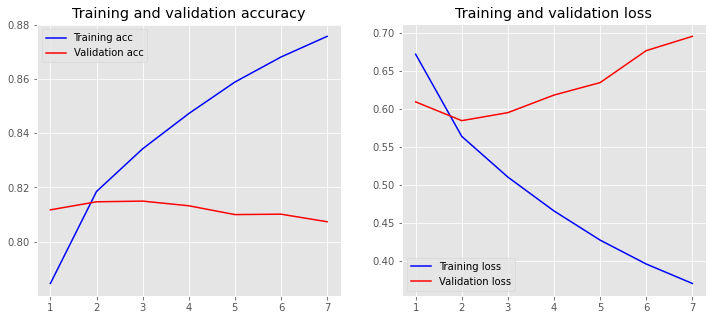

In [132]:
plot_history(history)

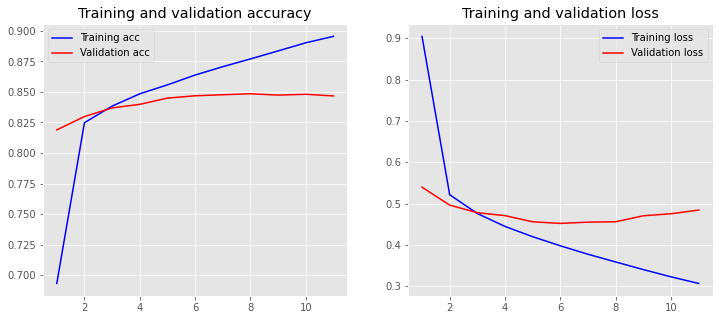

In [134]:
plot_history(history)

In [132]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer


In [135]:
before_vect = df[['narrative']]
columnTransformer = ColumnTransformer( [('tfidf',TfidfVectorizer(stop_words=None, max_features=100000),'narrative')],
remainder='drop')
vector_transformer = columnTransformer.fit(before_vect)
vectorized_df = vector_transformer.transform(before_vect)

In [79]:
vectorized_df

<592935x99272 sparse matrix of type '<class 'numpy.float64'>'
	with 32223236 stored elements in Compressed Sparse Row format>

In [137]:
targetTransformer = ColumnTransformer( [('E',OneHotEncoder(dtype='int'))])

In [144]:
y=df['Product'].to_frame()

In [42]:
y

,Product
0,"Credit reporting, credit repair services, or o..."
1,Debt collection
2,"Credit reporting, credit repair services, or o..."
3,Debt collection
4,"Credit reporting, credit repair services, or o..."
...,...
1823678,Bank account or service
1823679,Credit reporting
1823680,Mortgage
1823681,Mortgage


In [141]:
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [142]:
ros = RandomOverSampler(random_state=777)
X_ROS, y_ROS = ros.fit_sample(vectorized_df, y)
X_train, x_test, Y_train, y_test = train_test_split(X_ROS,y_ROS,test_size=0.3,random_state=42)
sgd = SGDClassifier(max_iter=1000, tol=1e-3)
sgd.fit(X_train, Y_train)
pred_sgd = sgd.predict(x_test)
print("Accuracy %s" % accuracy_score(pred_sgd,y_test))
print(classification_report(y_test,pred_sgd))

Accuracy 0.7989275484092732
                                                      precision    recall  f1-score   support

                         Checking or savings account       0.78      0.82      0.80     72885
                         Credit card or prepaid card       0.78      0.82      0.80     73008
Credit or consumer reporting, credit repair services       0.76      0.76      0.76     72446
                                     Debt collection       0.75      0.79      0.77     72432
         Money transfer or service, virtual currency       0.85      0.84      0.84     73035
                                            Mortgage       0.89      0.95      0.92     72579
                                       Personal loan       0.81      0.42      0.56     72688
                                        Student loan       0.91      0.93      0.92     72801
                               Vehicle loan or lease       0.69      0.85      0.76     72701

                              

In [139]:
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [140]:
smote = SMOTE(random_state=777,k_neighbors=18)
X_smote,y_smote = smote.fit_sample(vectorized_df,y)
X_train, x_test, Y_train, y_test = train_test_split(X_smote,y_smote,test_size=0.3,random_state=42)
sgd = SGDClassifier(max_iter=1000, tol=1e-3)
sgd.fit(X_train, Y_train)
pred_sgd = sgd.predict(x_test)
print("Accuracy %s" % accuracy_score(pred_sgd,y_test))
print(classification_report(y_test,pred_sgd))

C:\Users\virah\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Accuracy 0.8304777909330482
                                                      precision    recall  f1-score   support

                         Checking or savings account       0.83      0.86      0.84     72885
                         Credit card or prepaid card       0.82      0.86      0.84     73008
Credit or consumer reporting, credit repair services       0.78      0.76      0.77     72446
                                     Debt collection       0.79      0.82      0.80     72432
         Money transfer or service, virtual currency       0.88      0.88      0.88     73035
                                            Mortgage       0.92      0.96      0.94     72579
                                       Personal loan       0.84      0.50      0.62     72688
                                        Student loan       0.94      0.95      0.94     72801
                               Vehicle loan or lease       0.71      0.89      0.79     72701

                              

In [103]:
print("test")

test
